### Baseline Models

Simple If-Then Models

 - Home team always wins 
 
ML Models

 - LightGBM 
 - XGBoost
    

In [47]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
print('LGB version:', lgb.__version__)

from tqdm import tqdm

import shap

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'../data')


XGB version: 1.6.0
LGB version: 3.3.2


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train = pd.read_csv(DATAPATH / "processed" / "train.csv")
test = pd.read_csv(DATAPATH / "processed" / "test.csv")

train.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,TARGET
0,2022-06-16,42100406,1610612738,1610612744,2021,90.0,0.425,0.917,0.393,27.0,41.0,103.0,0.413,1.000,0.413,27.0,44.0,0,1,0
1,2022-06-13,42100405,1610612744,1610612738,2021,104.0,0.466,0.867,0.225,23.0,39.0,94.0,0.413,0.677,0.344,18.0,47.0,1,1,1
2,2022-06-10,42100404,1610612738,1610612744,2021,97.0,0.400,0.737,0.395,22.0,42.0,107.0,0.440,0.800,0.349,20.0,55.0,0,1,0
3,2022-06-08,42100403,1610612738,1610612744,2021,116.0,0.483,0.708,0.371,28.0,47.0,100.0,0.462,0.867,0.375,22.0,31.0,1,1,1
4,2022-06-05,42100402,1610612744,1610612738,2021,107.0,0.453,0.700,0.405,25.0,42.0,88.0,0.375,0.765,0.405,24.0,43.0,1,1,1


**Model - Home team always wins**

In [4]:
# train data

predict = np.ones((train.shape[0],))
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5906199991793525, 0.5)

In [6]:
# test data

predict = np.ones((test.shape[0],))
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5643451930355791, 0.5)

### ML Baseline Models

**Fix Datatypes for smaller memory footprint**

In [14]:
test['GAME_DATE_EST']

0                2022-12-22
1                2022-12-22
2                2022-12-21
3                2022-12-21
4                2022-12-21
               ...         
2637    2023-04-16 00:00:00
2638    2023-04-15 00:00:00
2639    2023-04-15 00:00:00
2640    2023-04-15 00:00:00
2641    2023-04-15 00:00:00
Name: GAME_DATE_EST, Length: 2642, dtype: object

In [36]:
def fix_datatypes(df):

    if df.GAME_DATE_EST.dtype == "O":
        df['GAME_DATE_EST'] = df['GAME_DATE_EST'].str.split(" ").str[0]
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)


**Basic Feature Engineering**

Because the basic data is post-game data, there would be data leakage if we used the data as is. We need to create features that are available before the game starts. Namely, we will do a rolling average for each stat for the last 5 games.

In [37]:
def add_rolling_means(df, location):
    
    location_id = location + "_TEAM_ID"

    # sort games by the order in which they were played for each home or visitor team
    df = df.sort_values(by = [location_id, 'GAME_DATE_EST'], axis=0, ascending=[True, True,], ignore_index=True)
    
    # rolling means
    feature_list = ['HOME_TEAM_WINS', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']
    
    if location == 'VISITOR':
        feature_list = ['HOME_TEAM_WINS', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

    roll_feature_list = []
    for feature in feature_list:
        roll_feature_name = location + '_' + feature + '_AVG_LAST_' + '5_' + location
        if feature == 'HOME_TEAM_WINS': #remove the "HOME_" for better readability
            roll_feature_name = location + '_' + feature[5:] + '_AVG_LAST_' + '5_' + location
        roll_feature_list.append(roll_feature_name)
        df[roll_feature_name] = df.groupby(['HOME_TEAM_ID'])[feature].rolling(5, closed= "left").mean().values

    return df

train = add_rolling_means(train, 'HOME')
train = add_rolling_means(train, 'VISITOR')
test = add_rolling_means(test, 'HOME')
test = add_rolling_means(test, 'VISITOR')

train

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,TARGET,HOME_TEAM_WINS_AVG_LAST_5_HOME,HOME_PTS_home_AVG_LAST_5_HOME,HOME_FG_PCT_home_AVG_LAST_5_HOME,HOME_FT_PCT_home_AVG_LAST_5_HOME,HOME_FG3_PCT_home_AVG_LAST_5_HOME,HOME_AST_home_AVG_LAST_5_HOME,HOME_REB_home_AVG_LAST_5_HOME,VISITOR_TEAM_WINS_AVG_LAST_5_VISITOR,VISITOR_PTS_away_AVG_LAST_5_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_5_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_5_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_5_VISITOR,VISITOR_AST_away_AVG_LAST_5_VISITOR,VISITOR_REB_away_AVG_LAST_5_VISITOR
0,2003-10-29,20300006,1610612740,1610612737,2003,88.0,0.323975,0.700195,0.160034,24.0,55.0,83.0,0.397949,0.736816,0.213989,18.0,58.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-10-31,20300024,1610612741,1610612737,2003,100.0,0.399902,0.758789,0.500000,27.0,53.0,94.0,0.399902,0.713867,0.583008,22.0,48.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-11-05,20300060,1610612744,1610612737,2003,99.0,0.446045,0.645020,0.278076,23.0,52.0,72.0,0.366943,0.500000,0.333008,19.0,43.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-11-08,20300084,1610612757,1610612737,2003,90.0,0.425049,0.899902,0.500000,28.0,41.0,83.0,0.437988,0.786133,0.099976,21.0,45.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-11-09,20300089,1610612760,1610612737,2003,81.0,0.378906,0.736816,0.056000,12.0,46.0,91.0,0.479004,0.789062,0.533203,16.0,41.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24366,2022-03-30,22101140,1610612752,1610612766,2021,114.0,0.470947,0.691895,0.364014,23.0,43.0,125.0,0.543945,0.881836,0.343018,39.0,40.0,0,0,0,0.6,108.2,0.426416,0.690137,0.369775,21.6,46.2,1.0,94.8,0.444971,0.728418,0.283203,22.6,46.0
24367,2022-04-02,22101161,1610612755,1610612766,2021,144.0,0.608887,0.810059,0.488037,38.0,47.0,114.0,0.482910,0.791992,0.366943,34.0,32.0,1,0,1,0.4,107.6,0.463135,0.800781,0.367773,24.6,42.2,1.0,99.6,0.461768,0.723437,0.316211,23.0,43.8
24368,2022-04-05,22101181,1610612748,1610612766,2021,144.0,0.570801,0.861816,0.547852,29.0,41.0,115.0,0.528809,0.722168,0.315918,34.0,31.0,1,0,1,0.4,109.0,0.480566,0.833203,0.375000,23.8,40.4,1.0,100.4,0.452393,0.737891,0.336987,23.8,45.6
24369,2022-04-08,22101208,1610612741,1610612766,2021,117.0,0.537109,0.799805,0.541992,25.0,31.0,133.0,0.604980,1.000000,0.475098,34.0,38.0,0,0,0,0.4,111.4,0.455176,0.799902,0.315967,22.8,42.6,1.0,97.8,0.436377,0.733887,0.330786,24.6,44.4


**Select Features**

In [38]:
target = train['TARGET']
test_target = test['TARGET']

category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS', 'PLAYOFF', 'CONFERENCE_x', 'CONFERENCE_y',]

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID',] #not really useful as-is

# non-rolling features, which would be data leakage
drop_columns1 = ['HOME_TEAM_WINS', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']
drop_columns2 = ['PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

drop_columns = drop_columns + drop_columns1
drop_columns = drop_columns + drop_columns2 

use_columns = [item for item in all_columns if item not in drop_columns]

train = train[use_columns]
test = test[use_columns]

**Options**

In [39]:
K_FOLDS = 5
SEED = 13

### LightGBM


In [50]:
%%time

NUM_BOOST_ROUND = 700
EARLY_STOPPING = 200
LOG_EVALUATION = 100

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
#train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

lgb_params= {
            'seed': SEED,
            'verbose': 0,           
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc', 
            #'num_leaves': 31,
            #'learning_rate': 0.05,
            #'feature_fraction': 0.9,
            #'bagging_fraction': 0.8,
            #'bagging_freq': 5,

            }


# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_lgbdataset = lgb.Dataset(train_df, label=train_target,)
    val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset )

    model =  lgb.train(lgb_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       num_boost_round = NUM_BOOST_ROUND,
                       callbacks=[log_evaluation(LOG_EVALUATION),early_stopping(EARLY_STOPPING,verbose=False)],
                       #verbose_eval= VERBOSE_EVAL,
                      )

    temp_oof = model.predict(val_df)
    temp_oof_shap = model.predict(val_df, pred_contrib=True)
    
    temp_test = model.predict(test)
    temp_test_shap = model.predict(test, pred_contrib=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    test_preds_shap += temp_test_shap/K_FOLDS
    

    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))





0it [00:00, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's auc: 0.63315
[200]	valid_0's auc: 0.627462


1it [00:01,  1.01s/it]

0.616 0.6345005050044514
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[100]	valid_0's auc: 0.630159
[200]	valid_0's auc: 0.623213


2it [00:02,  1.13s/it]

0.6060730406237177 0.6339032715515778
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[100]	valid_0's auc: 0.632394
[200]	valid_0's auc: 0.62124


3it [00:03,  1.14s/it]

0.5984817398440706 0.6347851218877343
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[100]	valid_0's auc: 0.642489
[200]	valid_0's auc: 0.63773


4it [00:04,  1.19s/it]

0.6183832581042266 0.6438021939182795
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[100]	valid_0's auc: 0.625738
[200]	valid_0's auc: 0.621661


5it [00:05,  1.11s/it]

0.6077144029544522 0.6293352862779068

Composite Train OOF CV Scores:

Accuracy Score: 0.5985392474662509
AUC Score: 0.6352224643566405
Optimal Threshold: 0.5995763230325595

Test data Scores:

Accuracy Score: 0.560560181680545
AUC Score: 0.62251149526758
CPU times: user 30 s, sys: 3.82 s, total: 33.8 s
Wall time: 5.62 s


**Feature Importance via Split - the number of times a feature is used in the model**

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

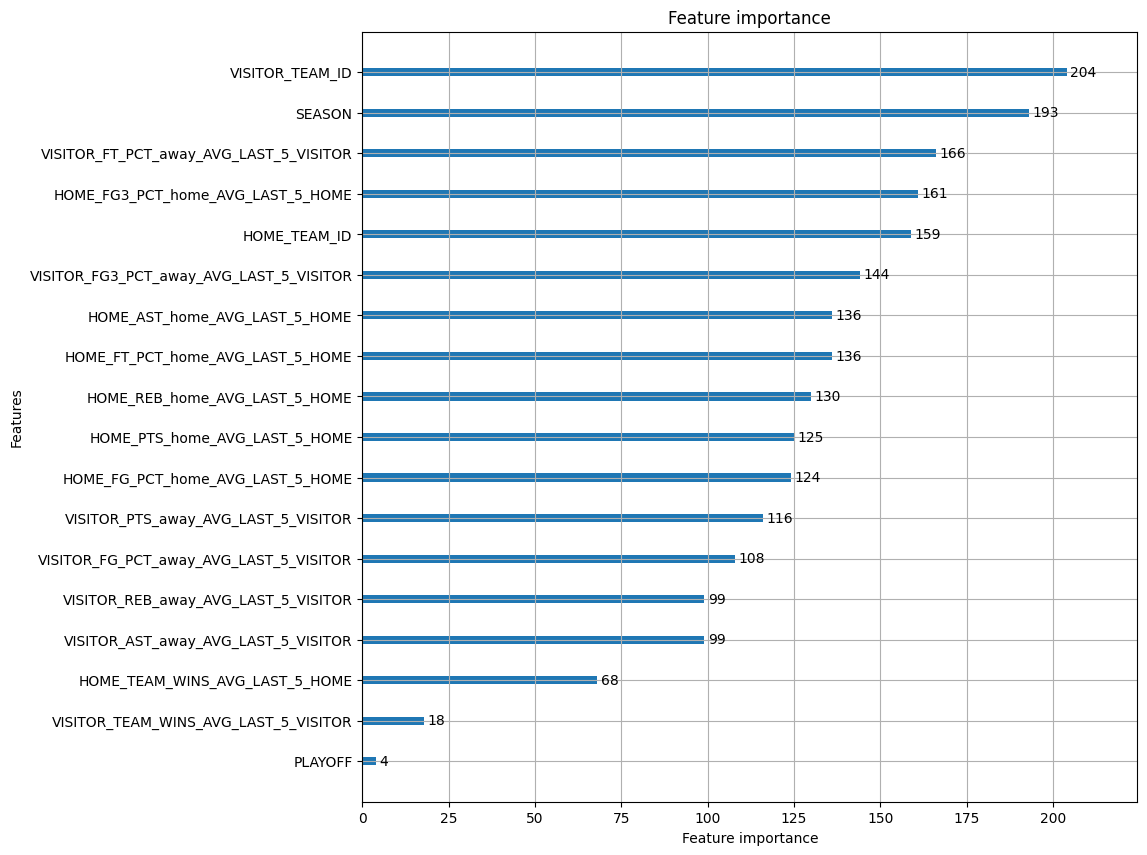

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='split', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

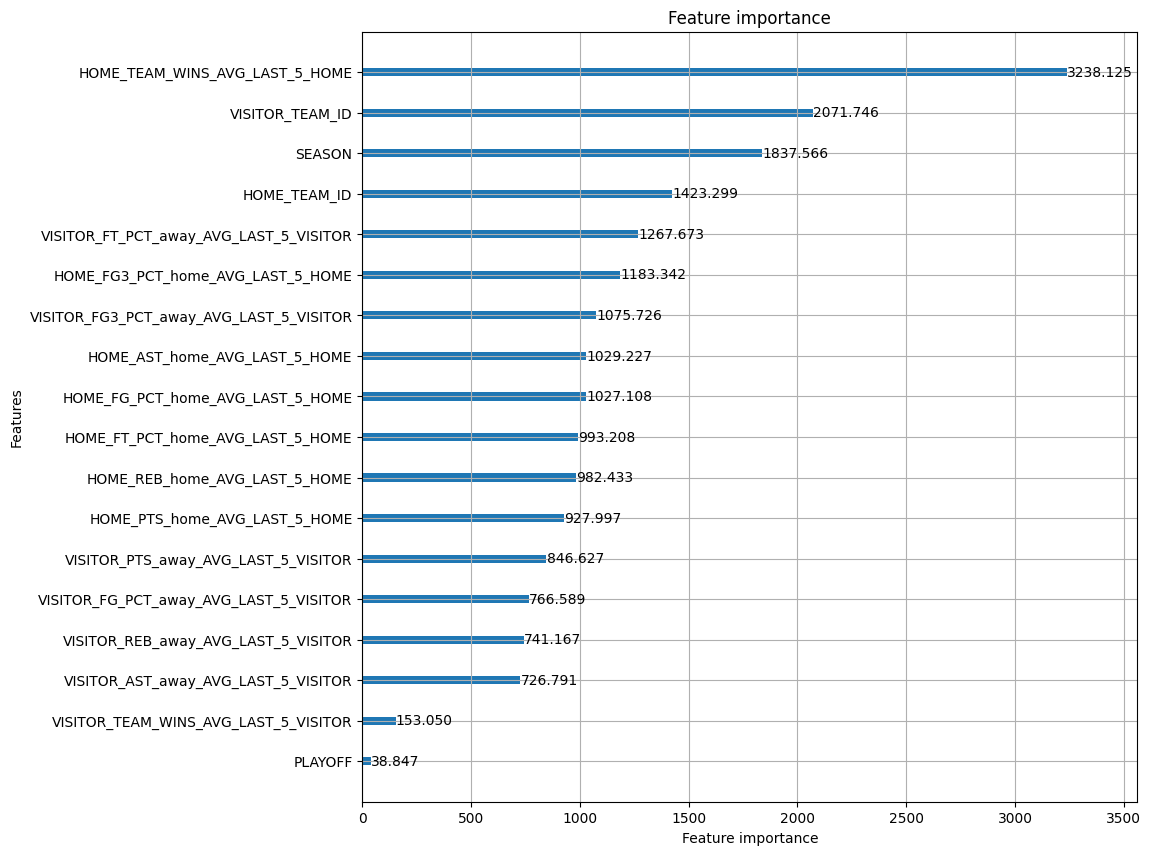

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


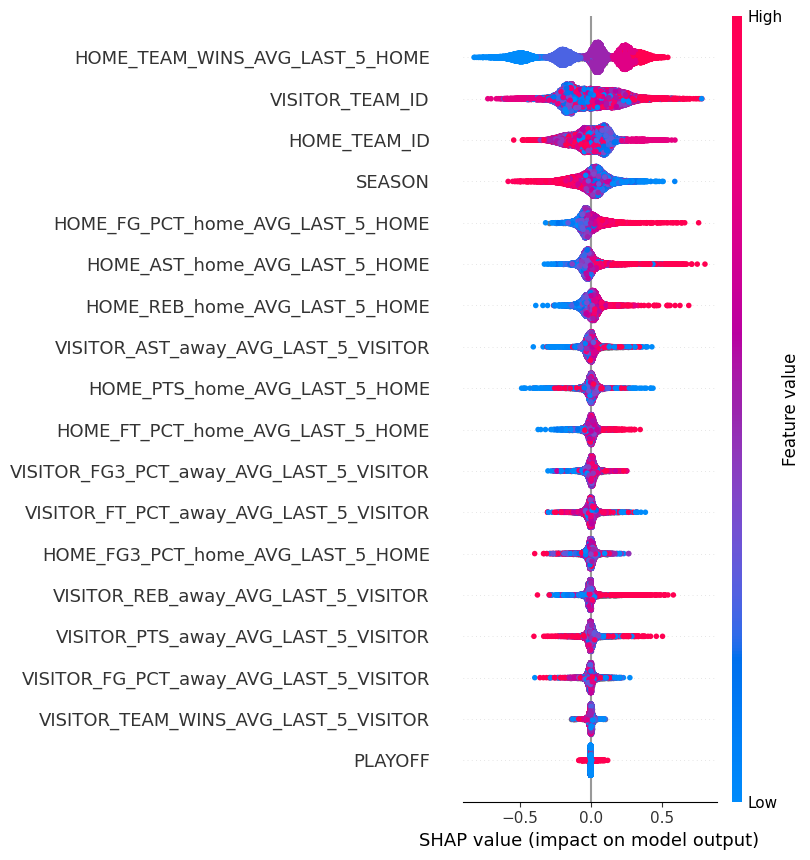

In [48]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

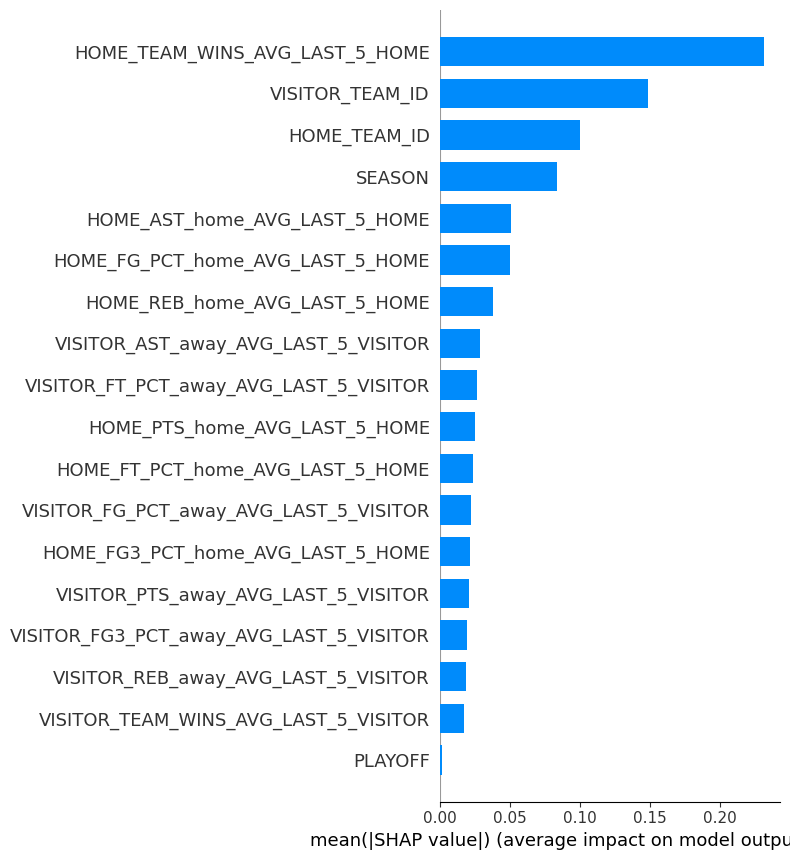

In [14]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")

### XGBoost


In [51]:
%%time

NUM_BOOST_ROUND = 700

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

xgb_params= {
            'seed': SEED,
            'eval_metric': 'auc',
             #'max_bin': 168, 
             #'max_depth': 1, #16
             #'alpha': 6.956941489832698, 
             #'gamma': 0.6029881527116713, 
             #'reg_lambda': 2.527966510426255, 
             #'colsample_bytree': 0.9087064850010729, 
             #'subsample': 0.31410604106509005, 
             #'min_child_weight': 7.877326540625619,
             #'num_parallel_tree' : 10,
             #'learning_rate': 0.03,  
            }

# K-fold cross validation

test_dmatrix = xgb.DMatrix(test)

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_dmatrix = xgb.DMatrix(train_df, label=train_target)
    val_dmatrix = xgb.DMatrix(val_df, label=val_target)

    model =  xgb.train(xgb_params, 
                       train_dmatrix, 
                       num_boost_round = NUM_BOOST_ROUND,
                      )

    temp_oof = model.predict(val_dmatrix)
    temp_oof_shap = model.predict(val_dmatrix, pred_contribs=True)
    temp_oof_shap_interact = model.predict(val_dmatrix, pred_interactions=True)
    
    temp_test = model.predict(test_dmatrix)
    temp_test_shap = model.predict(test_dmatrix, pred_contribs=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    test_preds_shap += temp_test_shap/K_FOLDS
    
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))



1it [01:58, 118.45s/it]

0.5105641025641026 0.5428187914557842


2it [03:55, 117.86s/it]

0.5217480508822323 0.531021805991185


3it [05:55, 118.85s/it]

0.5235945835043085 0.5507832624283877


4it [07:52, 118.11s/it]

0.559499384489126 0.546127301581498


5it [09:54, 118.80s/it]

0.515387771850636 0.5442037654182583

Composite Train OOF CV Scores:

Accuracy Score: 0.524188584793402
AUC Score: 0.5429611769707537
Optimal Threshold: 0.6184784770011902

Test data Scores:

Accuracy Score: 0.47274791824375473
AUC Score: 0.5788982373825926
CPU times: user 1h 5min 55s, sys: 4min 53s, total: 1h 10min 48s
Wall time: 9min 54s


**Feature Importance via Weight - the number of times a feature appears in a tree**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

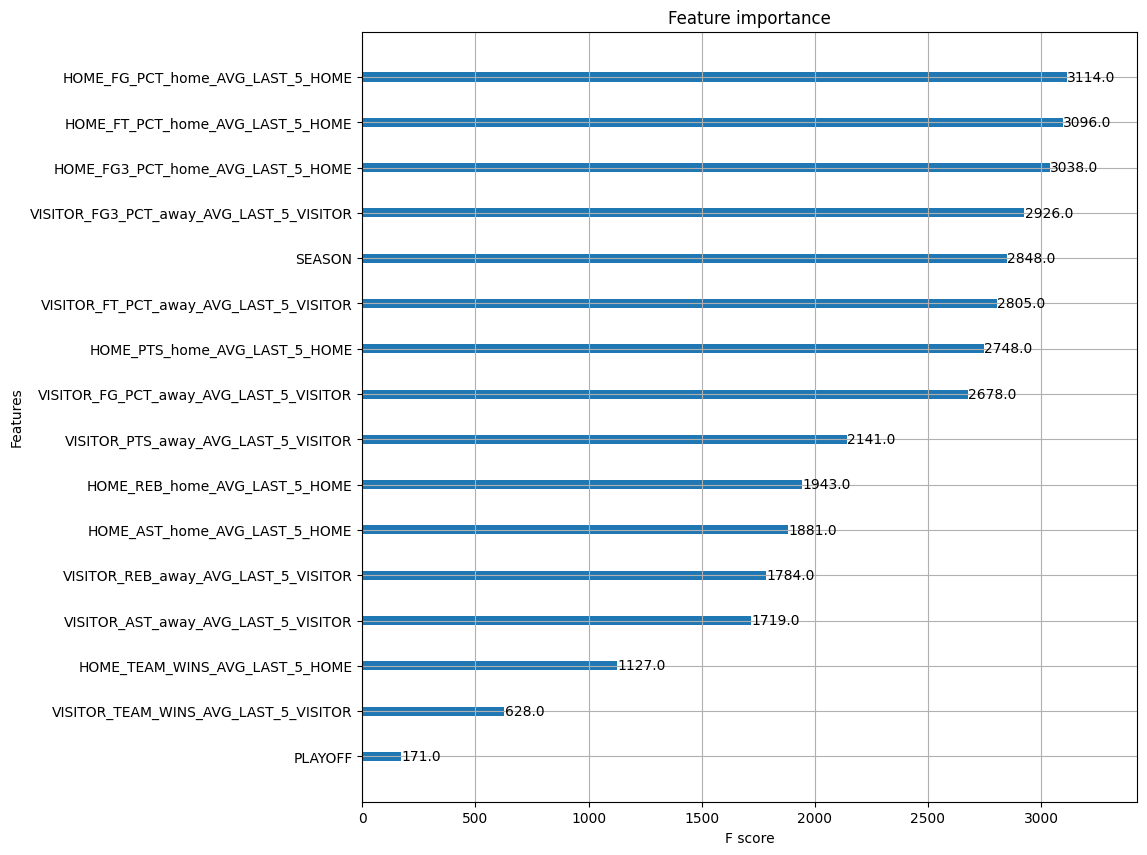

In [52]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

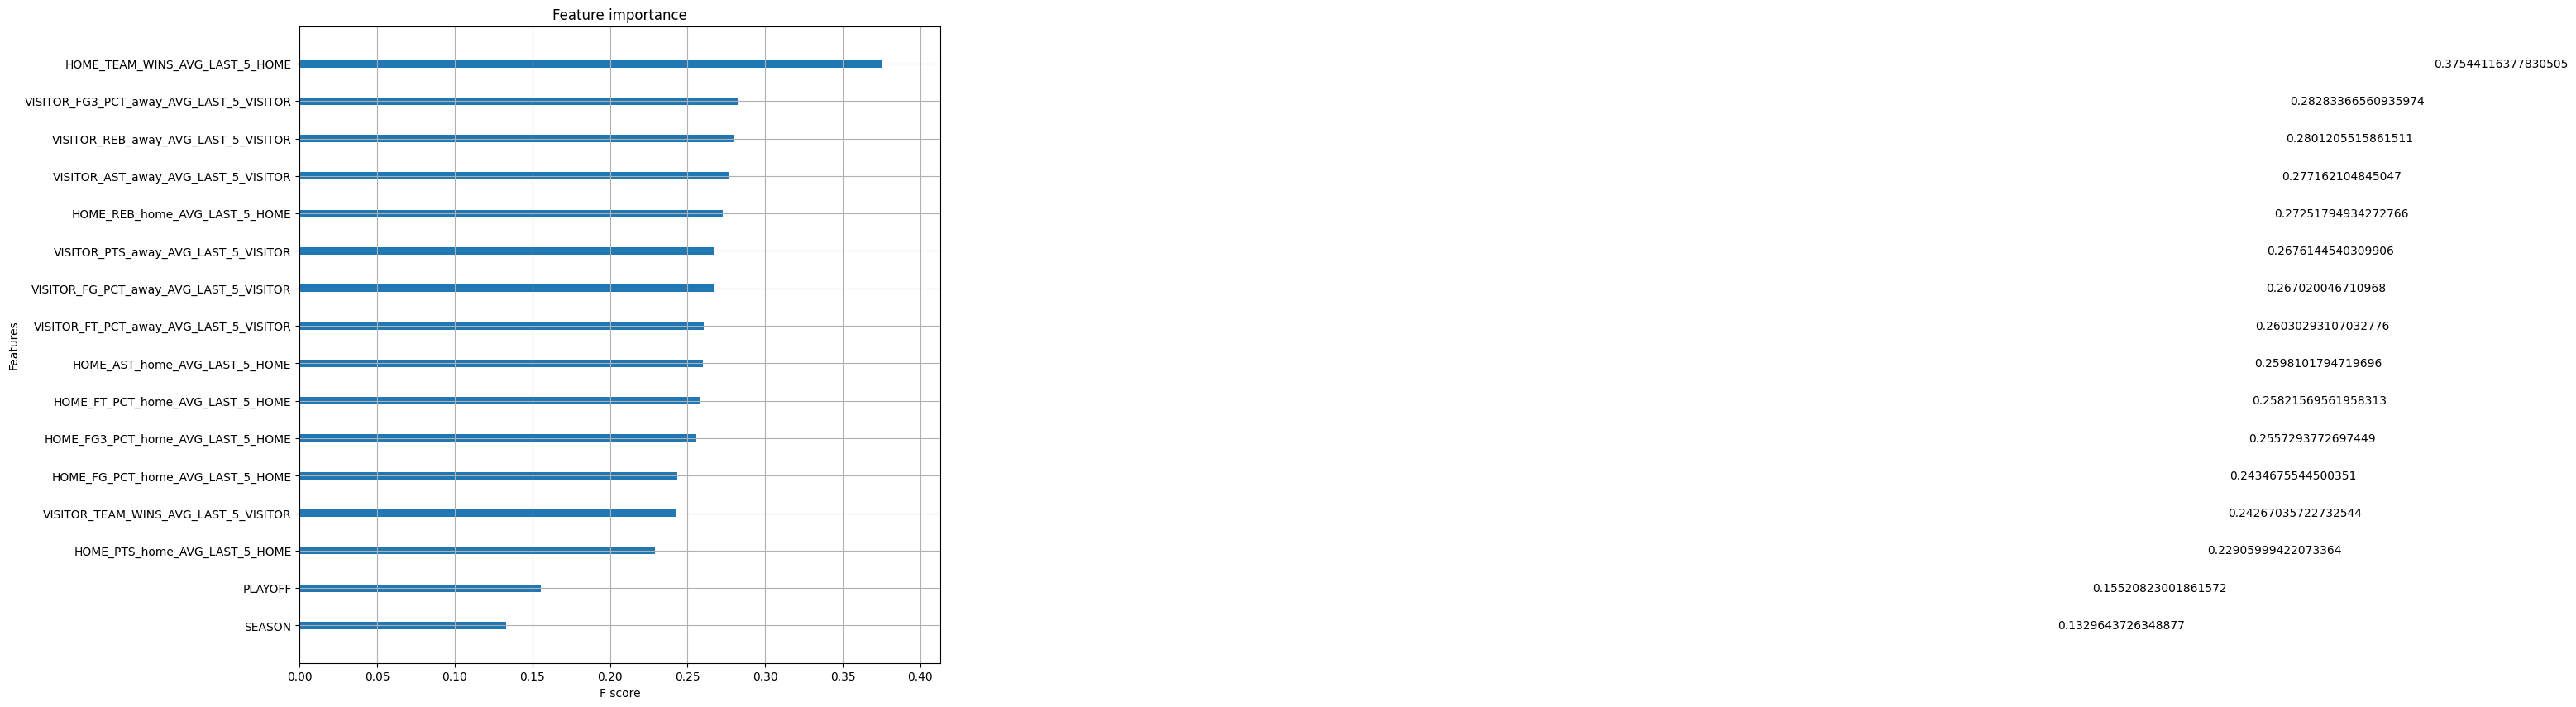

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


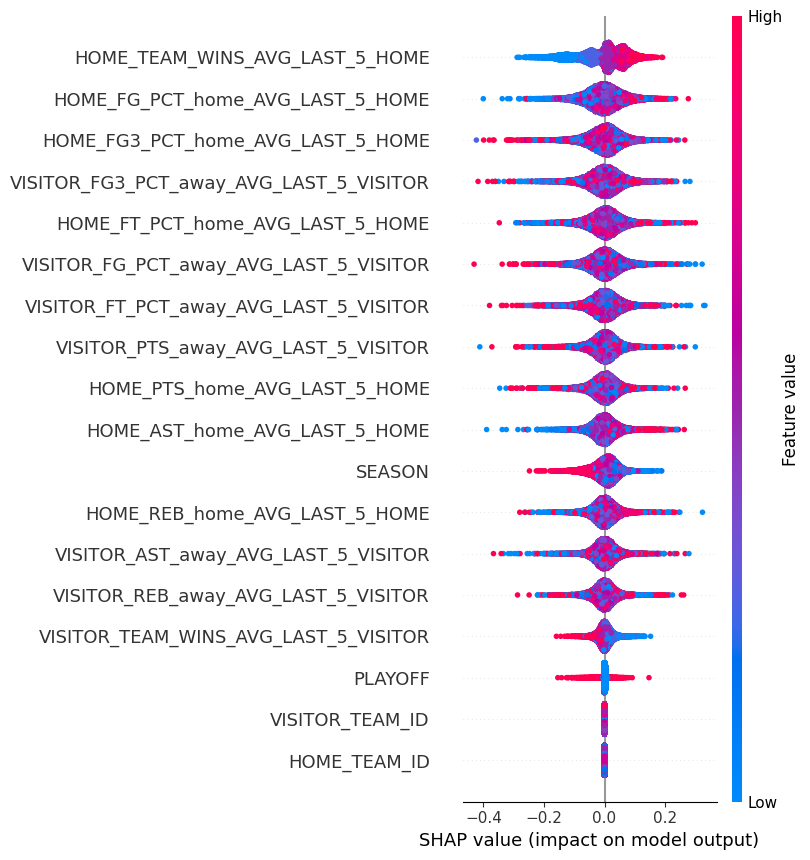

In [54]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

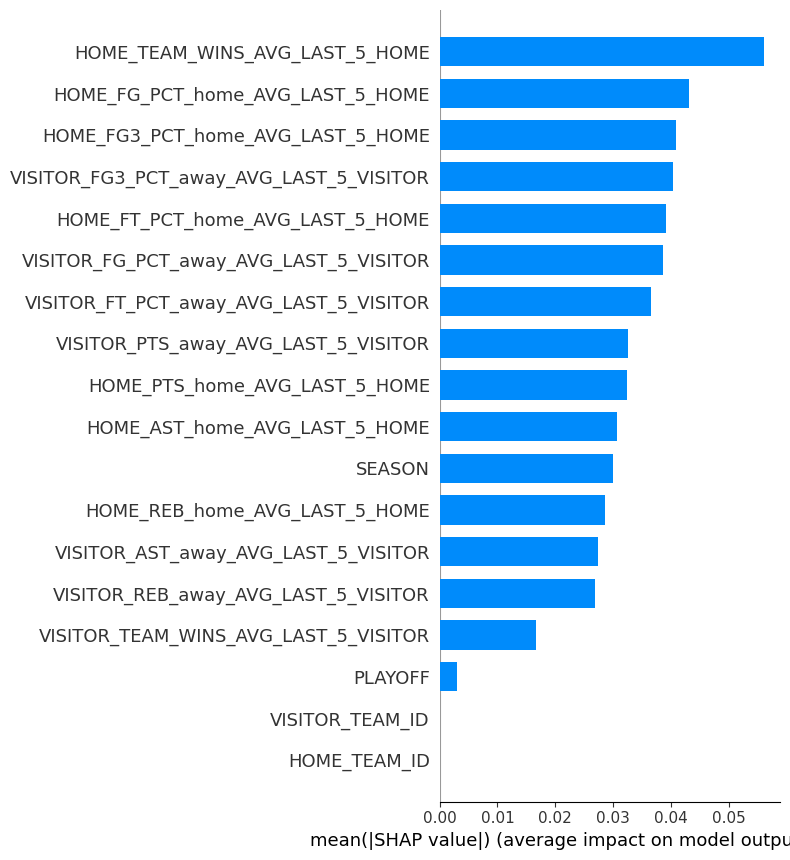

In [55]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")